# TP : Résolution de l'équation de Vlasov-Poisson 1D-1D par une méthode semi-lagrangienne

In [1]:
# Basic imports 
import numpy as np 
import matplotlib.pyplot as plt 

On s'intéresse à l'équation de Vlasov  (évolution de la distribution des électrons dans un plasma) couplée avec l'équation de Poisson (évolution du champ électrique) 

\begin{equation}
\begin{cases}
\partial_t f + v \,\partial_x f - E(x,t) \,\partial_v f = 0 \\ 
\\ 
\partial_x E = \rho(x,t) = 1 - \int f(x,v,t) \,dv 
\end{cases}
\end{equation} 


## Discrétisation de l'espace des phases 

On considère un espace des phases en deux dimensions (une d'espace et une de vitesse) $\Omega = ]-\pi, \pi[^2 \subset \mathbb{R}^2$ que l'on va discrétiser par une grille uniforme $\mathcal{M} = \{(x_i, v_j)\}_{i= 0\,, \cdots, \,n_x-1\,,\,j=0\,, \cdots,\, n_v-1, }\subset \Omega$ 

In [2]:
nx = 100; nv = 100
dx = 2*np.pi / (2*nx) ; dv =2*np.pi / (2*nv)
dt = 1e-2
L = np.pi   
x = np.linspace(-L, L, num=nx, dtype=float)
v = np.linspace(-L, L, num=nv, dtype=float)
xx, vv = np.meshgrid(x,v) 

## Condition initiale 

On se donne une condition initiale en distribution de particules $f_0(x,v)$ 

In [18]:
f = lambda x, v : (1 / 2*np.pi)*np.exp(-0.5*(x**2+v**2))

Text(0, 0.5, '$v$')

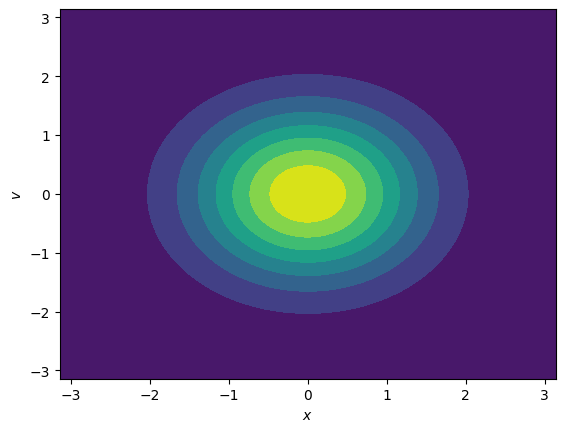

In [4]:

f_zero = f(xx, vv)
plt.contourf(x, v, f_zero)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')  

## Résolution de  l'équation de Poisson

La partie poisson du problème s'écrit 

\begin{equation}
\tag{P}
\partial_x E = \rho(x,t) = 1 - \int f(x, v, t) \,\text{d}v
\end{equation}

On va résoudre ce problème en discrétisant $f$ en modes de Fourier selon 
$$ f^n(x,v) = f(x,v, t_n) = \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} e^{i l.v} $$
Ainsi 
\begin{align*}
\rho^n(x, v) & = 1 - \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} \underbrace{\int e^{i l.v} \,\text{d}v}_{=0 \text{ si } l\neq 0 \text{ et } 2\pi \text{ sinon}} \\ 
             & = 1 - \sum\limits_{k} c^n_{k,0} \, e^{i k.x}  \\ 
             & = \sum\limits_{k} \tilde{c_k}^n \, e^{i k.x},         
\end{align*}
en posant $$\tilde{c_k}^n = 
            \begin{cases} 
                1 - c^n_{k,0} & \text { si } k=0 \\
                - c^n_{k,0} & \text{ sinon.}
            \end{cases} 
            $$
On écrit la somme de Fourier pour le champ électrique : 
$$ E^n(x) = \frac{1}{2\pi} \sum\limits_{j} d_j^n \, e^{i j.x} $$ 
donc 
$$ \frac{\text{d} E^n}{\text{d} x} = \sum\limits_{j} i j\, d_j^n \, e^{i j.x} $$

et par identification (unicité) des coefficients de Fourier on obtient $d_k^n = \frac{\tilde{c_k}^n}{ik} \text{ pour } k\neq 0$. La valeur de $d_0^n$ qui correspond à la moyenne du champ électrique peut être choisie librement et on prendra par exemple $d_0^n=0$.

### Calcul des coefficients de Fourier de $f$

On considère une fonction $f$ d'une variable $x$ 1D dont on cherche à calculer les coefficients de Fourier seulement à partir de sa connaissance sur une grille discrétisée $\{x_l\}_{l=0, \,\cdots,\, n_x-1}$.

Le $k$-ème coefficient de Fourier de $f$ noté $c_k$ est défini par 

$$ c_k = \sum\limits_{l} f_l \, e^{-ik\,x_l} $$ 

De sorte qu'on a l'égalité 
$$
\begin{pmatrix}
c_0 \\
\vdots \\ 
c_{n_x-1}
\end{pmatrix}
= 
\tilde{F}
\begin{pmatrix}
f_1 \\ 
\vdots \\ 
f_{n_x -1} 
\end{pmatrix}
$$

Où $\tilde{F}$ est la matrice définie par 
$$ \tilde{F} = [ \,e^{-ik\,x_l}\, ]_{k,l=\,0, \cdots,\, n_x-1} $$ 

In [73]:
def build_F_tilde(x):
    nx = len(x) 
    F_tilde = np.array([np.exp(-k*1j * x[l]) for k,l in np.ndindex((nx,nx))], dtype=complex)
    F_tilde.resize((nx,nx)) 
    return F_tilde

def fourier_coeffs_1D(f, F_tilde):
    c = F_tilde @ f 
    return c

## Discrétisation en fréquences

Afin de discrétiser les fonctions $f$ et $E$, nous allons tronquer l'espace de Fourier pour écrire des séries de Fourier finies selon 

$$ \tilde{f}(x) = \frac{1}{2\pi} \sum\limits_{k = -K}^{K} c_k(f) \, e^{ik.x} $$ 

On écrit une fonction qui reconstruit une fonction en calculant sa série de Fourier tronquée à partir de ses coefficients de Fourier 

In [124]:
def reconstuction(x, c):
    nx = len(x) 
    s = lambda x: (1/nx) * np.sum([c[k]*np.exp(1j*k*x) for k in range(len(c))])
    return np.array([s(_x) for _x in x]) 

In [130]:
g = lambda x : np.cos(x) + np.sin(2*x) + np.exp(x) 
g_h = g(x)

In [131]:
F = build_F_tilde(x) 
print(np.shape(F))
c = fourier_coeffs_1D(g_h, F) 

(100, 100)


In [134]:
rec = reconstuction(x, c)

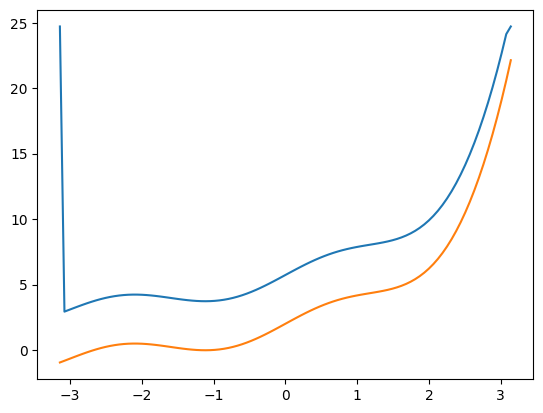

In [135]:
plt.plot(x, rec) 
plt.plot(x, g_h)

/home/murloc/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


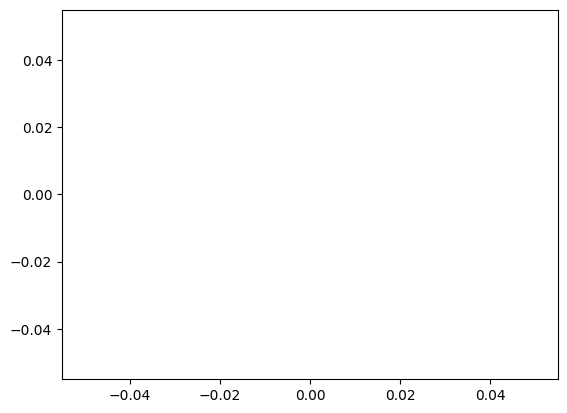

In [112]:
plt.plot(x, rec)

## Calcul des coefficients 2D 

Pour calculer les coefficients pour les séries de Fourier en deux dimensions on effectue simplement les calculs dimension par dimension. 

In [19]:
def fourier_coeffs_2D(x, v, f):
    nx = len(x) ; nv = len(v) 
    to_transform = []
    for _v in v:
        _f = lambda z: f(z,_v)
        _f_d = _f(x)
        F = build_F_tilde(x)
        c_x = fourier_coeffs_1D(_f_d, F)
        to_transform.append(c_x) 
    final_coeffs = [] 
    for element_to_transform in to_transform:
        F = build_F_tilde(v)
        c = fourier_coeffs_1D(element_to_transform, F)
        final_coeffs.append(c) 
    final_coeffs = np.array(final_coeffs)
    final_coeffs.resize((nx, nv))
    return np.array(final_coeffs)

In [20]:
c = fourier_coeffs_2D(x, v, f)

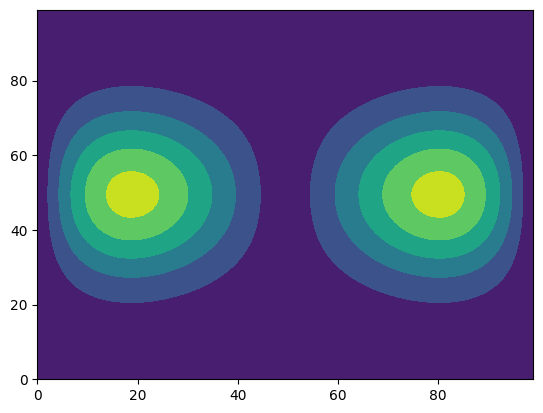

In [21]:
plt.contourf(np.abs(c))

In [22]:
import itertools as it 

In [48]:
## Not Needed by now 
def reconstuction_2D(x, v, c):
    nx = len(x) ; nv = len(v) 
    rec = np.zeros((nx,nv), dtype=complex)
    for k,l in np.ndindex((nx,nv)):
        rec[k,l] = np.sum([c[k,l] * np.exp(1j*k*x[k]) * np.exp(1j*l*v[l]) for k,l in np.ndindex((nx,nv))]) 
    return rec 

In [42]:
def solve_poisson(x,f):
    nx = len(x) 
    c = fourier_coeffs_2D(x, v, f)
    c_tilde = np.zeros(nx, dtype=complex)
    c_tilde[0] = 1 - c[0,0] 
    for i in range(1, nx):
        c_tilde[i] = - c[i,0]        
    d = np.zeros(nx, dtype=complex)
    d[0] = 0 
    for k in range(1,nx):  
        d[k] = (c_tilde[k]) / (k*1j)
    _E = reconstuction(x, d)
    return _E

In [43]:
E_zero = solve_poisson(x, f)

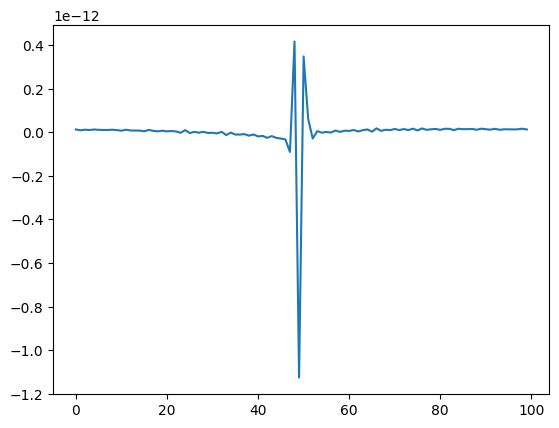

In [44]:
plt.plot(np.real(E_zero))

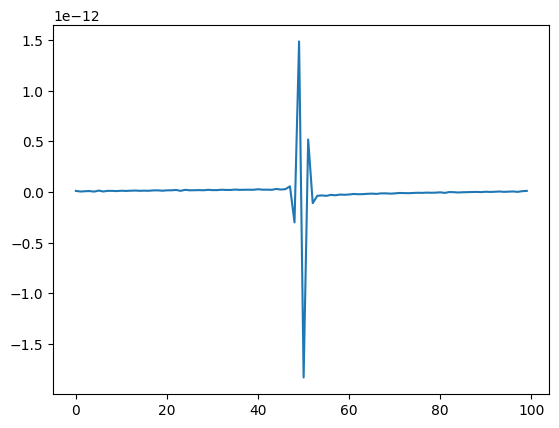

In [45]:
plt.plot(np.imag(E_zero))

## Transport dans l'équation de Vlasov


L'équation de Vlasov peut être décomposée en deux phénomènes décrivant son évolution :
- une advection en $v$ causée par le champ $E$ : 

\begin{equation}
\tag{a}
\partial_t f - E(x,t) \, \partial_v f = 0 
\end{equation}

- une advection en $x$ causée par le champ de vitesses : 

\begin{equation}
\tag{b}
\partial_t + v \,\partial_x f = 0
\end{equation}

Ces équations sont des équations de transport, dont les solutions analytiques peuvent être obtenues en appliquant la "méthode des caractéristiques".


### Méthode des caractéristiques



On considère une équation de transport 1D homogène à une dimension avec champ de vitesse $a(x,t)$: 

\begin{equation}
\tag{T}
\partial_t u + a(x,t)\,\partial_x u = 0
\end{equation}

Soit $(t,x) \in \mathbb{R}^{+} \times \mathbb{R}$ et  $X(s;t,x), s\in \mathbb{R}$ une courbe paramétrée lisse telle que $X(t;t,x) = x$.

On effectue le calcul de $\frac{d}{ds}u(X(s;t,x), t)$. 

\begin{align*} 
    \frac{\text{d}}{\text{d}s}u(X(s;t,x), s) = \partial_t u(X(s;t,x), s) + \frac{\text{d}X}{\text{d}s}(s;t,x)\, \partial_x u(X(s;t,x),s) & \quad \text{ (règle de la chaine)} 
\end{align*} 

On voit donc avec $(\text{T})$ que cette égalité se réduit à zéro si on impose la condition 

\begin{equation}
\tag{C}
\frac{\text{d}X}{\text{d}s} (s; t,x) = a(X(s;t,x),s) 
\end{equation}

On a ainsi réduit la résolution de l'EDP $(\text{T})$ à la résolution de l'EDO $(\text{C})$ dite "équation des caractéristiques". 


Dans le cas simple où le champ de vitesses $a$ est constant, l'équation $(\text{C})$ s'intégre en 
$$X(s;t,x) = as + b$$ 

et le coefficient b est déterminé par la condition

$$X(t;t,x) = x \implies b = x - at$$ 

de sorte que 

$$X(s;t,x) = x + a(s-t).$$

L'intérêt d'imposer l'équation des caractéristiques $\text{(C)}$ est de fixer 

$$\frac{\text{d}}{\text{d}s}u(X(s;t,x), s)= 0$$

et ainsi $\textbf{la solution est constante le long des courbes caractéristiques}$ de sorte que pour tout $(x,t)$

$$u(x,t) = u(X(t;t,x), t) = u(X(0;t,x), 0) = u_0(x-at)$$ 

où $u_0(x) = u(x, t=0)$ est la condition initiale. 



On voit ainsi ques les équations $(a)$ et $(b)$ sont analytiquement résolues par 

\begin{equation}
\tag{a*}
    f(x,v,t) = f_0(x, v + E(x)\,t)
\end{equation}
et
\begin{equation}
\tag{b*}
    f(x,v,t) = f_0(x - v\,t, v)
\end{equation}
respectivement. 

Seulement dans notre cas où l'on cherche à résoudre l'équation de Vlasov-Poisson (où l'évolution du champ électrique $E$ est couplée à l'équation de Vlasov) nous faison face à deux difficultés : 

1) Quel champ $E$ utiliser dans l'étape d'advection en $v$ ? Celui-ci évolue en effet simultanément par rapport à $f$. Cette question va nous amener à définir un schéma de $\textbf{splitting}$.
2) Les points $x-v\,t$ ou $v + E(x)\,t$ n'ont aucune raison particulière d'appartenir au maillage $\mathcal{M}$. Ce qui va nous amener à définir une étape $\textbf{d'interpolation}$ dans le schéma. 

## Interpolation en séries de Fourier 

On suppose connus la décomposition en série de fourier tronquée de f à l'étape $n$ selon : 

$$ f^n(x, v) = \frac{1}{2\pi}\sum\limits_{k,l} c_{k,l}^n \, e^{i k.x}e^{i l.v} $$ 

L'interpolation consiste ainsi à évaluer cette expression aux points d'interpolation $x - v\Delta t$ ou $v + E(x)\frac{\Delta t}{2}$ par exemple. 